<a href="https://colab.research.google.com/github/mikepmanning/pneumoniakaggle/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Overview**

The goal of this project is to develop a CNN that can examine images of lung x-rays to determine if the patient has clear and healthy lungs, or pneumonia, either viral or bacterial.

**Description of Data**
The images used in this project are a kaggle dataset (https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data). This group of images is a selection of chest x-rays of children ages 1-5, all gathered from the Guangzhou Women and Children's Medical Center in Guangzhou. These x-rays were obtained through routine medical care, and were screened for clarity and graded by two expert physicians, and validated by a third expert.

**Summary of Methods**
The first step is to resize these images to a more processable size (300x300) and then split the pneumonia pictures up between bacterial and viral images. The initial set also only contains 16 validation images, 8 bacterial and 8 normal, so we also move some of the training images into the validation folder (in a routine 80/20 split as is typical).

**Summary of the Model**

I first started with a basic model, a sequential model with CNN layers, MaxPooling layers, BatchNormalization and then flattening it into a few dense layers with a Dropout layer before the final dense layer with the softmax activation for my 3 options. This resulted in an accuracy of 52%.

Afterwards, I extended that model to include several CNN layers with BatchNormalization and wrapping up with a MaxPooling layer and repeating with a few more CNN/MaxPooling layers. This again was flattened with a few Dense layers and dropout layer. This improved our accuracy to 65%.

Lastly, I took advantage of Transfer Learning and utilized the DenseNet121 model, which uses advanced CNN blocks and pooling, and linked it to the same Dense layers. This increased our accuracy to 79.3%.

**Future Thoughts**
One thing I noticed when looking at other models that use this dataset (viewable at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code) is that some of them convert the images to grayscale rather than RGB. That is something I could try in the future, given that x-rays are generally very close to being grayscale to begin with.


In [1]:
#I assume this is needed - we used it in all our other projects

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# install initial data from kaggle

!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                          94KB  2024-09-02 10:53:57          35540        630  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12           7211        130  1.0              
mohamedyosef101/2024-olympics-medals-and-economic-status      2024 Olympics Medals and Economic status              2KB  2024-10-13 12:39:58           1512         23  1.0              
abdulszz/spotify-most-streamed-songs

In [3]:
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:25<00:00, 130MB/s]
100% 2.29G/2.29G [00:25<00:00, 97.8MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [5]:
#see the size of the directories
import os
import shutil
from PIL import Image

main_dir = "chest_xray/"
count = {"test":0, "train":0, "val":0}
for f in ["test", "train", "val"]:
  for label in ["PNEUMONIA", "NORMAL"]:
    print(main_dir + f + "/" + label)
    count[f] += len(os.listdir(main_dir + f + "/" + label))

print(count)


def resize_images(dir):
  for image in os.listdir(dir):
    with open(os.path.join(dir, image)) as i:
        im = Image.open(os.path.join(dir, image))
        im = im.resize((300, 300))
        im.save(os.path.join(dir, image))

# We need to split up each pnuemonia image into a separate folder for viral/bacterial
# We also need to resize our images so they are easier to process and it's better to do it here
for f in ["test", "train", "val"]:
  dir = os.path.join(main_dir, f)
  pn_dir = os.path.join(dir, "PNEUMONIA")
  nor_dir = os.path.join(dir, "NORMAL")
  bact_dir = os.path.join(dir, "BACTERIA")
  viral_dir = os.path.join(dir, "VIRAL")

  #resize normal images
  resize_images(nor_dir)

  os.mkdir(bact_dir)
  os.mkdir(viral_dir)
  for image in os.listdir(pn_dir):
    with open(os.path.join(pn_dir, image)) as i:
        im = Image.open(os.path.join(pn_dir, image))
        im = im.resize((300, 300))
        im.save(os.path.join(pn_dir, image))
    if "bacteria" in image:
      shutil.move(os.path.join(pn_dir, image), bact_dir)
    if "virus" in image:
      shutil.move(os.path.join(pn_dir, image), viral_dir)

  shutil.rmtree(pn_dir)






chest_xray/test/PNEUMONIA
chest_xray/test/NORMAL
chest_xray/train/PNEUMONIA
chest_xray/train/NORMAL
chest_xray/val/PNEUMONIA
chest_xray/val/NORMAL
{'test': 624, 'train': 5216, 'val': 16}


In [6]:

count = {"test": {}, "train": {}, "val": {}}
for f in ["test", "train", "val"]:
  for label in ["BACTERIA", "VIRAL", "NORMAL"]:
    count[f][label] = 0
    count[f][label] += len(os.listdir(main_dir + f + "/" + label))

print(count)


{'test': {'BACTERIA': 242, 'VIRAL': 148, 'NORMAL': 234}, 'train': {'BACTERIA': 2530, 'VIRAL': 1345, 'NORMAL': 1341}, 'val': {'BACTERIA': 8, 'VIRAL': 0, 'NORMAL': 8}}


In [7]:
# There are no validation images for viral pneumonia and only 8 for normal/bacteria.
# I think we want to add more images to the validation from the training folder.
# we've typically done 80:20

import random

for label in ["BACTERIA", "VIRAL", "NORMAL"]:
  total_size = count["train"][label] + count["val"][label]
  samples_to_add = (total_size*0.2) - count["val"][label]  #number of samples to move
  samples_added = 0

  source_dir = main_dir + "train/" + label
  dest_dir = main_dir + "val/" + label

  for image in os.listdir(source_dir):
    if random.randint(1, 10) <= 2: #20% of samples
      shutil.move(source_dir + "/" + image, dest_dir)
      samples_added += 1

    if samples_added >= samples_to_add:
      continue



In [8]:
#Check new sample spread
count = {"test": {}, "train": {}, "val": {}}
for f in ["test", "train", "val"]:
  for label in ["BACTERIA", "VIRAL", "NORMAL"]:
    count[f][label] = 0
    count[f][label] += len(os.listdir(main_dir + f + "/" + label))

print(count)

{'test': {'BACTERIA': 242, 'VIRAL': 148, 'NORMAL': 234}, 'train': {'BACTERIA': 2031, 'VIRAL': 1044, 'NORMAL': 1094}, 'val': {'BACTERIA': 507, 'VIRAL': 301, 'NORMAL': 255}}


In [9]:
#import general libraries needed

from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from IPython.display import display # Library to help view images
from PIL import Image # Library to help view images
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from tensorflow.keras.preprocessing import image
import os, shutil # Library for navigating files
np.random.seed(1)

In [12]:
train_dir = main_dir + "train"
val_dir = main_dir + "val"
test_dir = main_dir + "test"

# #For some reason, we have this folder that we need to remove
#shutil.rmtree(train_dir + "/.ipynb_checkpoints")
#shutil.rmtree(val_dir + "/.ipynb_checkpoints")
#shutil.rmtree(test_dir + "/.ipynb_checkpoints")

In [13]:
#Create data generators to normalize images - data will flow from directory into the model through here

#Augment training data
train_datagen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator (rescale=1./255)

t_size = (300, 300)

# Create the actual flowing mechanisms

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=t_size,
    batch_size=20,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=t_size,
    batch_size=20,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=t_size,
    batch_size=20,
    class_mode='categorical')

train_generator.class_indices

Found 4169 images belonging to 3 classes.
Found 1063 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


{'BACTERIA': 0, 'NORMAL': 1, 'VIRAL': 2}

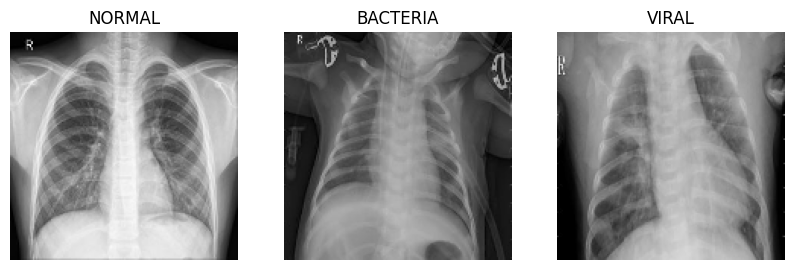

In [14]:
# Lets see the images
from tensorflow.keras.preprocessing import image
img = image.load_img(os.path.join(train_dir + "/NORMAL", os.listdir(train_dir + "/NORMAL")[1]), target_size=(150,150))
bact_img = image.load_img(os.path.join(train_dir + "/BACTERIA", os.listdir(train_dir + "/BACTERIA")[1]), target_size=(150,150))
viral_img = image.load_img(os.path.join(train_dir + "/VIRAL", os.listdir(train_dir + "/VIRAL")[1]), target_size=(150,150))

images = [img, bact_img, viral_img]
labels = ["NORMAL", "BACTERIA", "VIRAL"]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
j = 0
for i in range(3):
  axes[j].imshow(images[i])
  axes[j].set_title(labels[i])
  axes[j].axis("off")
  j += 1
plt.show()

In [15]:
# Create a plot funtion to visualize models
def plot_history(history, title):
  plt.figure(figsize=(12,4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='validation')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.suptitle(title)
  plt.show()

In [16]:
def Base_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape=(300, 300, 3)))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(3, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [17]:
model = Base_CNN()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43808)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,803,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,823,747 (10.77 MB)

 Trainable params: 2,823,555 (10.77 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 124s 513ms/step - accuracy: 0.4638 - loss: 3.7663 - val_accuracy: 0.4770 - val_loss: 2.2383
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 123s 483ms/step - accuracy: 0.5683 - loss: 0.9561 - val_accuracy: 0.4770 - val_loss: 0.9269
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 103s 475ms/step - accuracy: 0.6030 - loss: 0.9127 - val_accuracy: 0.5898 - val_loss: 0.8080
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 141s 473ms/step - accuracy: 0.6160 - loss: 0.8714 - val_accuracy: 0.5889 - val_loss: 1.4957
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 102s 472ms/step - accuracy: 0.6042 - loss: 0.8461 - val_accuracy: 0.5193 - val_loss: 1.4275
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 161s 572ms/step - accuracy: 0.6110 - loss: 0.8461 - val_accuracy: 0.4920 - val_loss: 1.4709


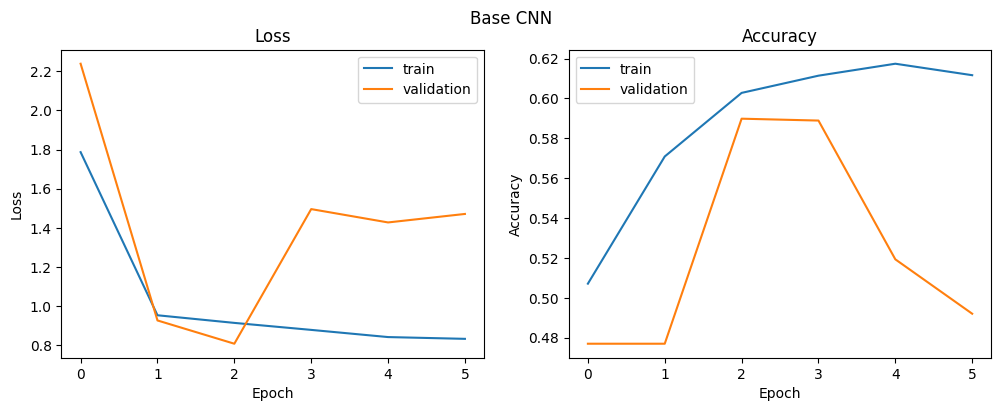

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5277 - loss: 0.9344
test_acc: 0.5224359035491943


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])

plot_history(history, "Base CNN")
test_loss, test_acc =model.evaluate(test_generator, steps = 50)

print('test_acc:', test_acc)

52% success rate on the initial model. I wanted to try and ladd some more layers with normalization to see if that can increase the accuracy of the model.

In [20]:
def Extended_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape=(300, 300, 3)))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(3, activation='softmax'))

  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

backend.clear_session()
model = Extended_CNN()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300, 300, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 300, 300, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 300, 300, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 175232)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      22,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,719,011 (86.67 MB)

 Trainable params: 22,718,115 (86.66 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 152s 608ms/step - accuracy: 0.5027 - loss: 8.0796 - val_accuracy: 0.2785 - val_loss: 47.3199
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 185s 617ms/step - accuracy: 0.5240 - loss: 1.0971 - val_accuracy: 0.2738 - val_loss: 14.6647
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 113s 529ms/step - accuracy: 0.5501 - loss: 0.9429 - val_accuracy: 0.5466 - val_loss: 1.0131
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 161s 613ms/step - accuracy: 0.5702 - loss: 0.9775 - val_accuracy: 0.5390 - val_loss: 0.8929
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 109s 510ms/step - accuracy: 0.5495 - loss: 0.9567 - val_accuracy: 0.4939 - val_loss: 1.1686
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 113s 528ms/step - accuracy: 0.5601 - loss: 0.9214 - val_accuracy: 0.5786 - val_loss: 0.8378
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 141s 516ms/step - accuracy: 0.5786 - loss: 0.9144 - val_accuracy: 0.3641 - val_loss: 1.5727
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 113s 529ms/step - accuracy: 0.5450

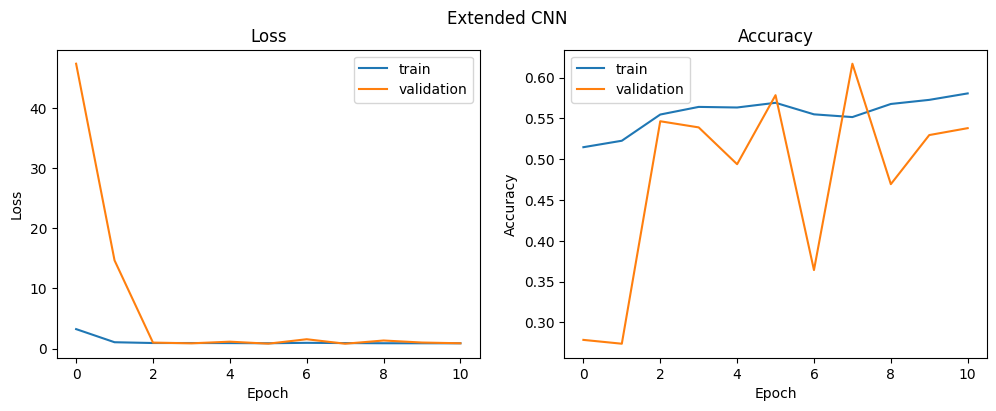

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6567 - loss: 0.7731 
test_acc: 0.6570512652397156


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [21]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])

plot_history(history, "Extended CNN")
test_loss, test_acc =model.evaluate(test_generator, steps = 50)

print('test_acc:', test_acc)

**Extended CNN Results**
We achieved 65% success with the Extended CNN model. This is a pretty good increase.

Next step is to try and use an existing model to hopefully improve upon our existing success. When trying the cat and dog assignment previously, I used the DenseNet121 model and had great success with it, so going to try and use it again here.

In [22]:
#Going to try and use the DenseNet121 - I had some success with this in the cat and dog exercise

from keras.applications import DenseNet121

# Trying DenseNet121 .
backend.clear_session()
dn121 = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (300, 300, 3), classes = 3, classifier_activation="softmax")

dn121.trainable = False

dn121.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 306, 306, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 75, 75, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 75, 75, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 75, 75, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
def modeldn121():
  backend.clear_session()
  modeldn121 = models.Sequential()
  modeldn121.add(dn121) # Add the DenseNet121 weights
  modeldn121.add(layers.Flatten())
  modeldn121.add(layers.Dense(1024, activation = 'relu')) #using 1024 to match with the last relu activation step
  modeldn121.add(layers.Dropout(0.5))
  modeldn121.add(layers.Dense(3, activation = 'softmax'))

  modeldn121.compile(optimizer = 'adam',
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])


  return modeldn121

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 177s 686ms/step - accuracy: 0.5879 - loss: 22.1882 - val_accuracy: 0.7225 - val_loss: 0.6352
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 109s 510ms/step - accuracy: 0.6876 - loss: 0.7156 - val_accuracy: 0.7291 - val_loss: 0.6120
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 108s 504ms/step - accuracy: 0.7129 - loss: 0.6703 - val_accuracy: 0.7234 - val_loss: 0.5937
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 107s 500ms/step - accuracy: 0.6750 - loss: 0.6882 - val_accuracy: 0.7328 - val_loss: 0.5937
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 163s 598ms/step - accuracy: 0.6922 - loss: 0.6773 - val_accuracy: 0.7357 - val_loss: 0.5942
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 106s 493ms/step - accuracy: 0.6947 - loss: 0.6763 - val_accuracy: 0.6707 - val_loss: 0.6154
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 143s 501ms/step - accuracy: 0.7099 - loss: 0.6521 - val_accuracy: 0.7375 - val_loss: 0.5551
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 108s 504ms/step - accuracy: 0.6937 

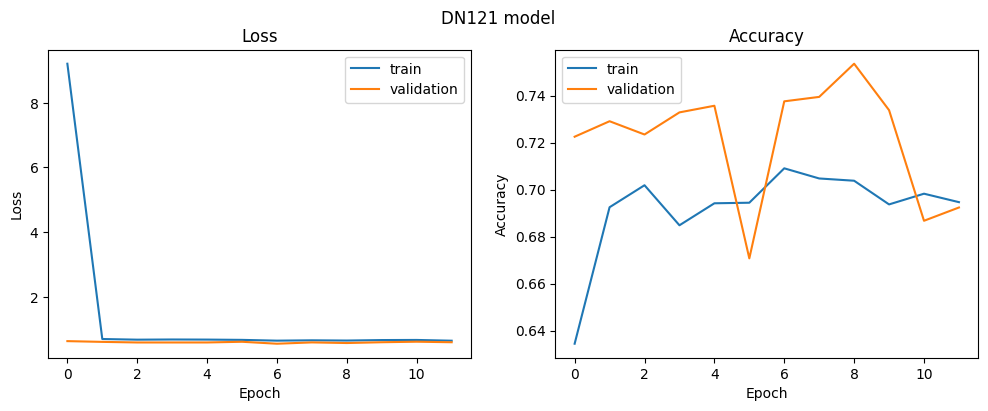

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.8088 - loss: 0.5285
test_acc: 0.7932692170143127


In [24]:
model = modeldn121()

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])


plot_history(history, "DN121 model")

test_loss, test_acc = model.evaluate(test_generator, steps = 50)
print('test_acc:', test_acc)

This model results in 79.3% accuracy, the best we've achieved so far.

One thing I noticed when looking at other models that use this dataset (viewable at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code) is that some of them convert the images to grayscale rather than RGB. That is something I could try in the future, given that x-rays are generally very close to being grayscale to begin with.

